# Setup notebook

In [1]:
import os
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

In [2]:
wdir = defs.ROOT / "data"

# Pre-process Mongla Tidal Data

Import data to pandas dataframe

In [3]:
freq = "30 min"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime")).interpolate(method="time", limit=1, limit_direction="both")

Find highs and lows

In [4]:
data[["high", "low"]] = False
distance = n_per_hour * 8

hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]

data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

Find and remove outliers

In [5]:
dt = pd.Timedelta("30 days")
stds = 3

# Find and remove high water outliers
r_high = data.elevation.loc[data.high == True].rolling(window=dt, center=True)
top = r_high.mean() + stds * r_high.std()
bot = r_high.mean() -  stds * r_high.std()
highs_excl = data.loc[data.high == True].loc[~data.loc[data.high == True].elevation.between(bot, top)]
data.loc[highs_excl.index, "high"] = False

# Find and remove low water outliers
r_low = data.elevation.loc[data.low == True].rolling(window=dt, center=True)
top = r_low.mean() + stds * r_low.std()
bot = r_low.mean()  -  stds * r_low.std()
lows_excl = data.loc[data.low == True].loc[~data.loc[data.low == True].elevation.between(bot, top)]
data.loc[lows_excl.index, "low"] = False

Calculate rolling mean for the data and interpolate for missing values

In [6]:
data["high_roll"] = data.loc[data.high==True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = data.loc[data.low==True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

Smooth rolling means with Lowess Smooth

In [7]:
window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int)
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

Calculate smoothed amplitude

In [8]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

Find springs and neaps

In [9]:
data[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

Plot subset of data to make sure it looks correct

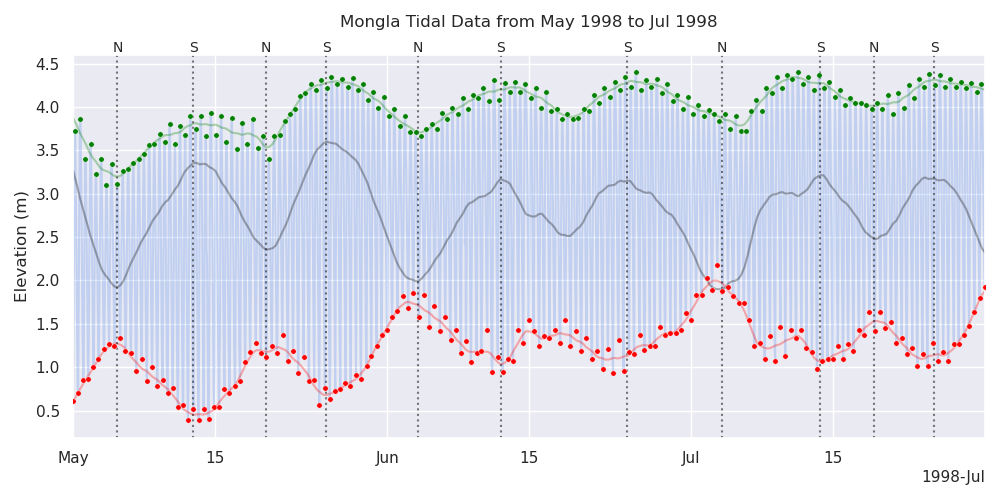

In [10]:
start = pd.to_datetime("1998-05-01")
end = start + pd.Timedelta("90D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

sns.scatterplot(data=highs_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.scatterplot(data=lows_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

# Astronomical model of the tides

Set model parameters

In [11]:
lat = 22.4833
start = "1998"
end = "2014"
elev = data.loc[start:end].elevation.values
time = mdates.date2num((data.loc[start:end].index - pd.Timedelta("6 hours")).to_pydatetime())

Create astronomical model with and without nodal correction

In [12]:
coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, verbose=False)

Reconstruct tidal curves using both models and combine with original data into one df

In [14]:
tide_model = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False)
df = pd.DataFrame(data={"modeled":tide_model.h}, index=pd.to_datetime(tide_model.t_mpl, unit="D") + pd.Timedelta("6 hours"))
tides = df.join(other=data.elevation, how="right").rename(columns={"elevation": "observed"})
tides["residual"] = tides.observed - tides.modeled

Plot observed vs modeled tides

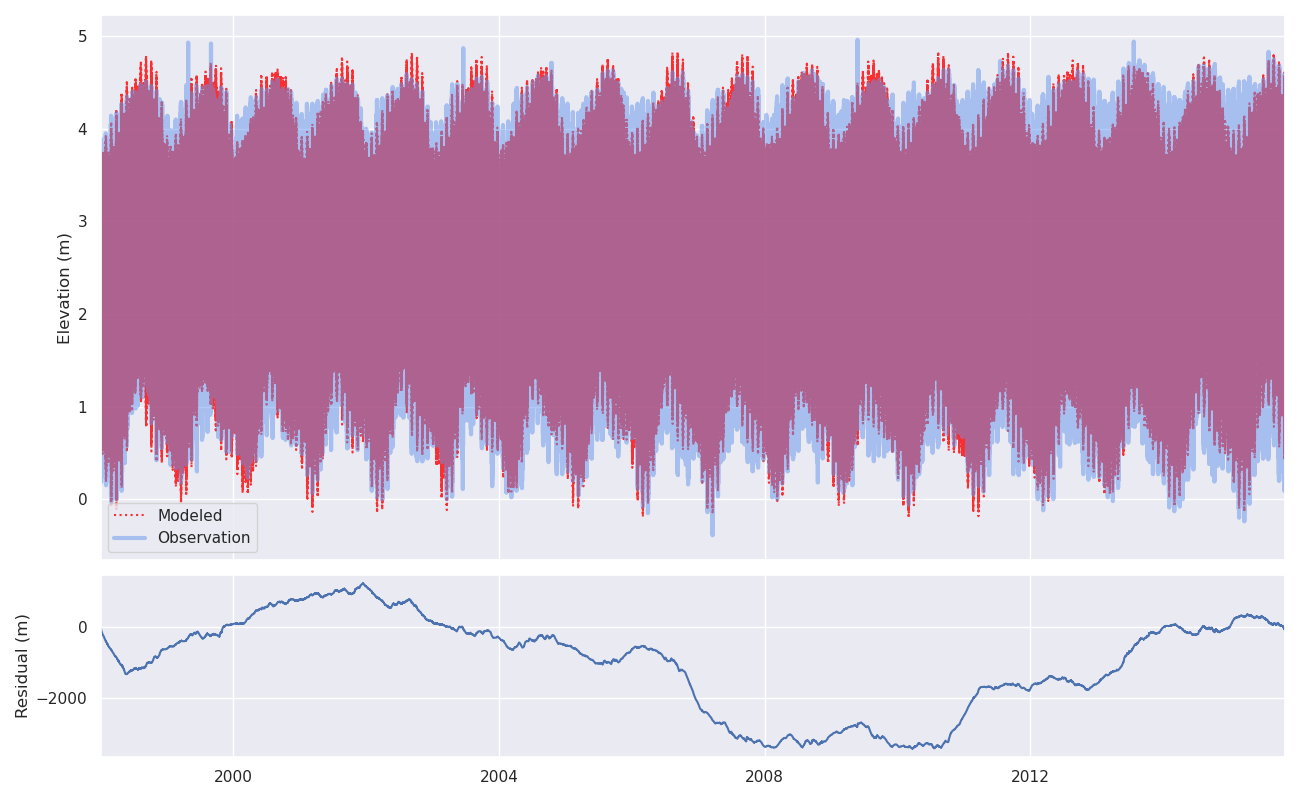

In [15]:
pdata = tides.loc["1998":]

fig = plt.figure(figsize=(13, 8))
axs = fig.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})


sns.lineplot(data=pdata.modeled, color="red", alpha=0.8, ax=axs[0], ls=":", label="Modeled")
sns.lineplot(data=pdata.observed, color="cornflowerblue", alpha=0.5, ax=axs[0], ls="-", lw=3, label="Observation")
sns.lineplot(data=pdata.residual.cumsum().reset_index(), x="datetime", y="residual", ax=axs[1])

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

axs[0].xaxis.set(major_locator=locator, major_formatter=formatter)
axs[0].tick_params(axis='x')

axs[0].set_ylabel("Elevation (m)")
axs[1].set_ylabel("Residual (m)")

axs[1].set_xlim(pdata.index[0], pdata.index[-1])
axs[1].set(xlabel=None)
fig.tight_layout()

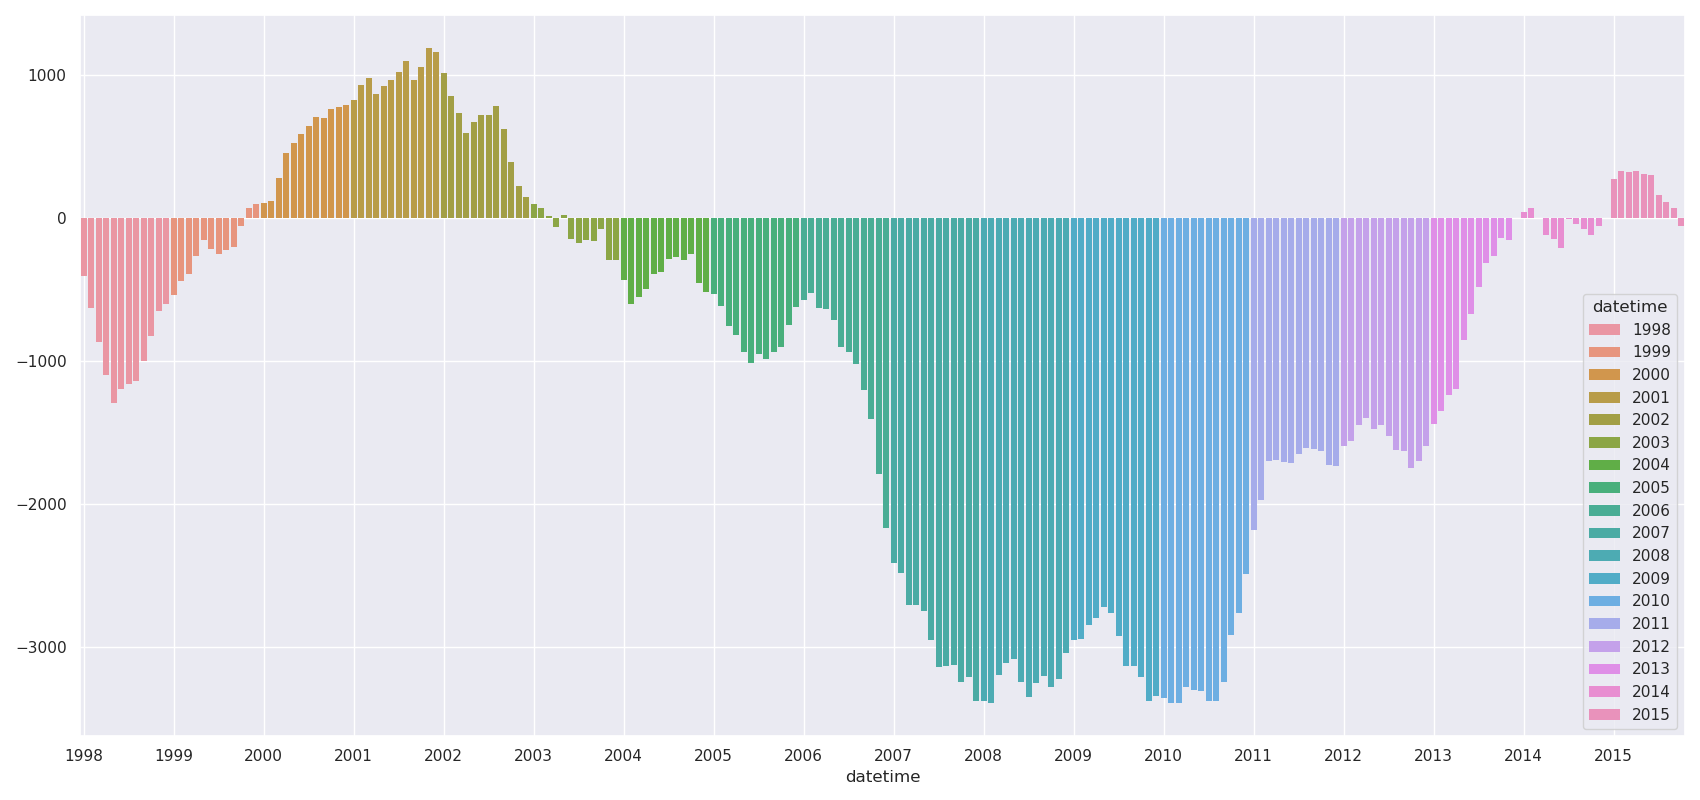

In [18]:
group = tides.loc["1998":].groupby(pd.Grouper(freq="M")).residual.sum().cumsum()

fig = plt.figure(figsize=(17, 8))
ax = fig.subplots()

sns.barplot(x=group.reset_index().datetime.dt.strftime("%Y-%m"), y=group.values, hue=group.index.year, lw=0, ax=ax, dodge=False)

locs = ax.get_xticks()[::12]
labels = group.reset_index().datetime.dt.strftime("%Y")[::12]

ax.set_xticks(locs)
ax.set_xticklabels(labels)
ax.grid(True)


fig.tight_layout()

# Amplify tides

In [141]:
freq = "1H"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)

# index = pd.date_range(start="2020", end="2040", freq=freq, closed="left", name="datetime")
index = pd.date_range(start="2020", periods=18.61*365.25*24, freq=freq, closed="left", name="datetime")
vals = utide.reconstruct(t=mdates.date2num((index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h
tides = pd.DataFrame(data={"elevation": vals}, index=index)

tides[["high", "low"]] = False
distance = n_per_hour * 8

hi = find_peaks(x=tides.elevation.values, distance=distance)[0]
lo = find_peaks(x=tides.elevation.values * -1, distance=distance)[0]

tides.loc[tides.iloc[hi].index, "high"] = True
tides.loc[tides.iloc[lo].index, "low"] = True

tides["high_roll"] = tides.loc[tides.high==True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["low_roll"] = tides.loc[tides.low==True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["amp_roll"] = tides.high_roll - tides.low_roll

window = pd.Timedelta("27 hour")
exog = (tides.index - tides.index[0]).total_seconds().astype(int)
frac = window / pd.Timedelta(freq) / len(tides)
delta = window * 500 / pd.Timedelta(freq)
endogs = (tides.high_roll.values, tides.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

tides.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + tides.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
tides.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + tides.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
tides["amp_smooth"] = tides.high_smooth - tides.low_smooth

tides[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=tides.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=tides.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
tides.loc[tides.iloc[hi].index, "spring"] = True
tides.loc[tides.iloc[lo].index, "neap"] = True

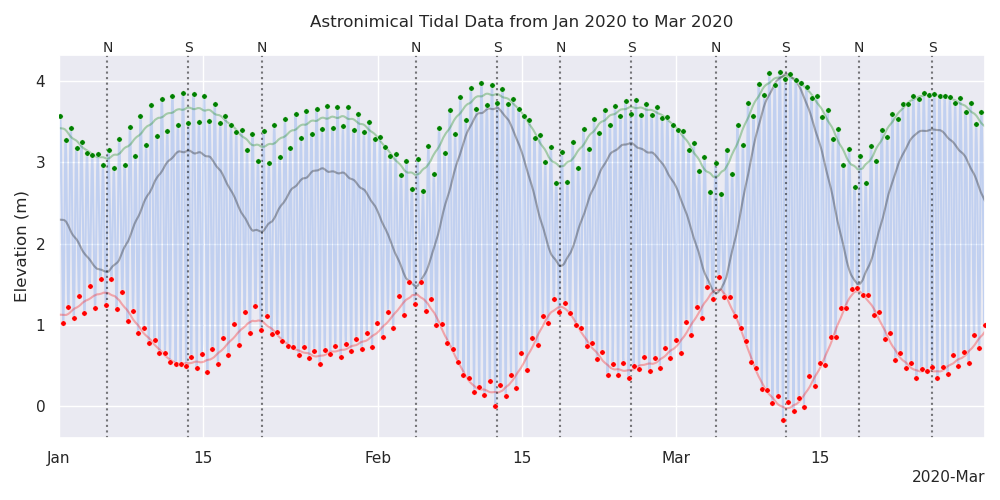

In [134]:
start = pd.to_datetime("2020-01-01")
end = start + pd.Timedelta("90D")

pdata = tides.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

sns.scatterplot(data=highs_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.scatterplot(data=lows_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronimical Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [135]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , lin_ts, ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    lin_ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], lin_ts, data))

In [142]:
phase_start = pd.to_datetime("2015-10-01")
monthly = data.elevation.groupby(pd.Grouper(freq="D")).agg(["max", "min"]).groupby(pd.Grouper(freq="MS")).mean()
monthly["TR"] = monthly["max"] - monthly["min"]
monthly["time"] = (monthly.index - phase_start) / pd.Timedelta("365.25 days")

MTR = monthly.loc["1998":"2009"].TR.mean()
beta = MTR * 0.037
nodal_freq = 18.61

In [143]:
daily = tides.elevation.groupby(by=pd.Grouper(freq="D")).agg(["max", "min"])
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})

time = (monthly.index - phase_start) / pd.Timedelta("365.25 days")
monthly["nodal"] = beta * np.cos(2 * np.pi / nodal_freq * time)

monthly["MHW_n"] = monthly.MHW - monthly.nodal / 2
monthly["MLW_n"] = monthly.MLW + monthly.nodal / 2

In [144]:
lms = monthly.apply(func=lm_tides, result_type="reduce")

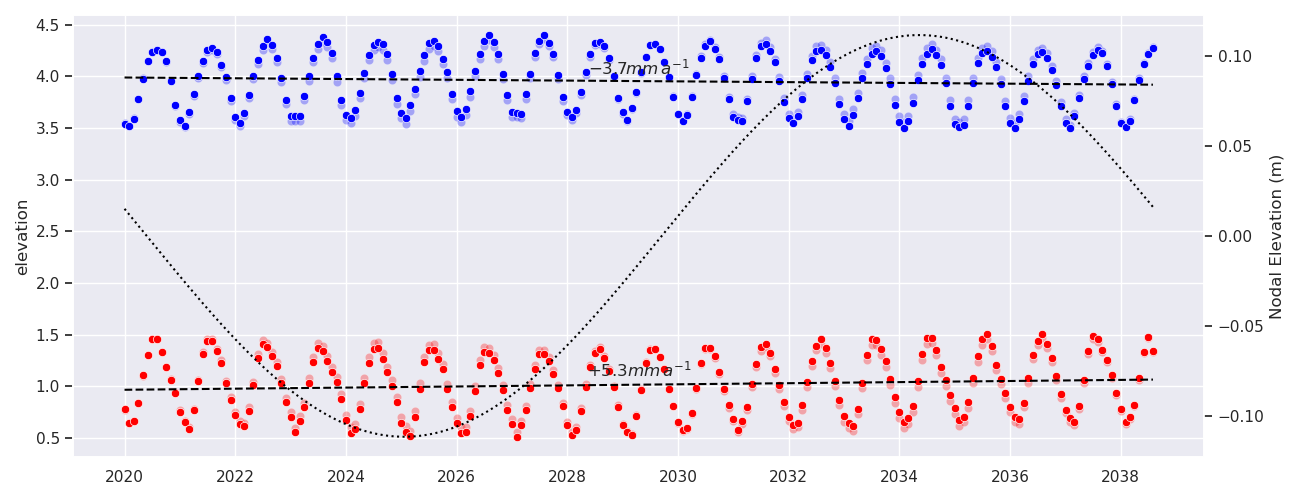

In [145]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()


sns.scatterplot(data=lms.MHW.ts, color="blue", alpha=0.3, ax=ax)
sns.scatterplot(data=lms.MHW_n.ts, color="blue", ax=ax)
sns.lineplot(data=lms.MHW_n.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MHW_n.lin_ts.index.mean(), y=lms.MHW_n.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MHW_n.coef * 1000), fontsize="large", fontweight="bold")

sns.scatterplot(data=lms.MLW.ts, color="red", alpha=0.3, ax=ax)
sns.scatterplot(data=lms.MLW_n.ts, color="red", ax=ax)
sns.lineplot(data=lms.MLW_n.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MLW_n.lin_ts.index.mean(), y=lms.MLW_n.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MLW_n.coef * 1000), fontsize="large", fontweight="bold")

ax1 = ax.twinx()
sns.lineplot(data=monthly.nodal, color="black", ls=":", ax=ax1, zorder=1, label="Nodal Tide", legend=False)
ax1.set_ylabel("Nodal Elevation (m)")
ax1.grid(False)

ax.set_ylabel("elevation")
ax.set_xlabel("")
fig.tight_layout()